# Imports et Configuration

In [3]:
# Installation (nécessaire sur Colab)
!pip install transformers -q
!pip install vaderSentiment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from tqdm import tqdm

# Configuration NLTK
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

# Configuration Visuelle
sns.set(style="whitegrid")
print("Bibliothèques chargées (y compris Transformers).")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


/Users/yasminchahraoui/projet-churn-hybride/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Bibliothèques chargées (y compris Transformers).


# Chargement des Données

In [4]:
# Chargement
df = pd.read_csv('../src/data/telco_prep.csv')

# Nettoyage basique
if 'PromptInput' in df.columns:
    df.drop(columns=['PromptInput'], inplace=True)

# Suppression des lignes vides s'il y en a
df = df.dropna(subset=['CustomerFeedback'])

print(f"Dimensions : {df.shape}")
print("Exemple de feedback brut :")
print(df['CustomerFeedback'].iloc[0])

Dimensions : (7032, 25)
Exemple de feedback brut :
i have been using the dsl internet service from this provider for the past month and so far, i am satisfied with the service. the connection has been reliable and the speed is sufficient for my needs. the monthly charges are reasonable at $29.85 and i appreciate the convenience of paying through electronic check. overall, i have had a positive experience and would recommend this provider to others.


# PRE-TRAITEMENT DU TEXTE

In [5]:
# 1. Configuration des Stopwords (CRUCIAL : On garde la négation)
stop_words = set(stopwords.words('english'))
# Liste des mots à NE PAS supprimer car ils changent le sens
negation_words = {'not', 'no', 'nor', 'never', 'neither', 'hardly', 'scarcely'}
# On retire ces mots de la liste des stopwords
stop_words = stop_words - negation_words

lemmatizer = WordNetLemmatizer()

def clean_text_smart(text):
    if not isinstance(text, str):
        return ""

    # 1. Minuscules
    text = text.lower()

    # 2. Suppression caractères spéciaux mais garde la ponctuation basique (! et ?) pour VADER
    # VADER utilise "!" pour intensifier le sentiment.
    text = re.sub(r'[^a-z\s!?]', '', text)

    # 3. Tokenization (découpage en mots)
    words = text.split()

    # 4. Suppression stopwords (sauf négations) + Lemmatisation simple
    # On fait une lemmatisation verbe (v) par défaut, suffisant ici
    cleaned_words = [lemmatizer.lemmatize(w, pos='v') for w in words if w not in stop_words]

    return " ".join(cleaned_words)

# Application
print("Nettoyage du texte en cours...")
df['cleaned_feedback'] = df['CustomerFeedback'].apply(clean_text_smart)

print("Nettoyage terminé.")
print("Avant : ", df['CustomerFeedback'].iloc[2])
print("Après : ", df['cleaned_feedback'].iloc[2])

Nettoyage du texte en cours...
Nettoyage terminé.
Avant :  i recently signed up for dsl internet service with this provider two months ago on a month-to-month contract. unfortunately, i have already decided to churn and switch to a different provider. the monthly charges of $53.85 were reasonable, but i found the internet service to be unreliable and slow. additionally, having to mail in a check for payment was inconvenient and outdated. i would not recommend this provider to others looking for reliable and convenient internet service.
Après :  recently sign dsl internet service provider two months ago monthtomonth contract unfortunately already decide churn switch different provider monthly charge reasonable find internet service unreliable slow additionally mail check payment inconvenient outdated would not recommend provider others look reliable convenient internet service


# ANALYSE DE SENTIMENT

Chargement du modèle Deep Learning...


Device set to use mps:0


Calcul des scores en cours sur les 3 modèles...


100%|██████████| 7032/7032 [03:02<00:00, 38.55it/s]


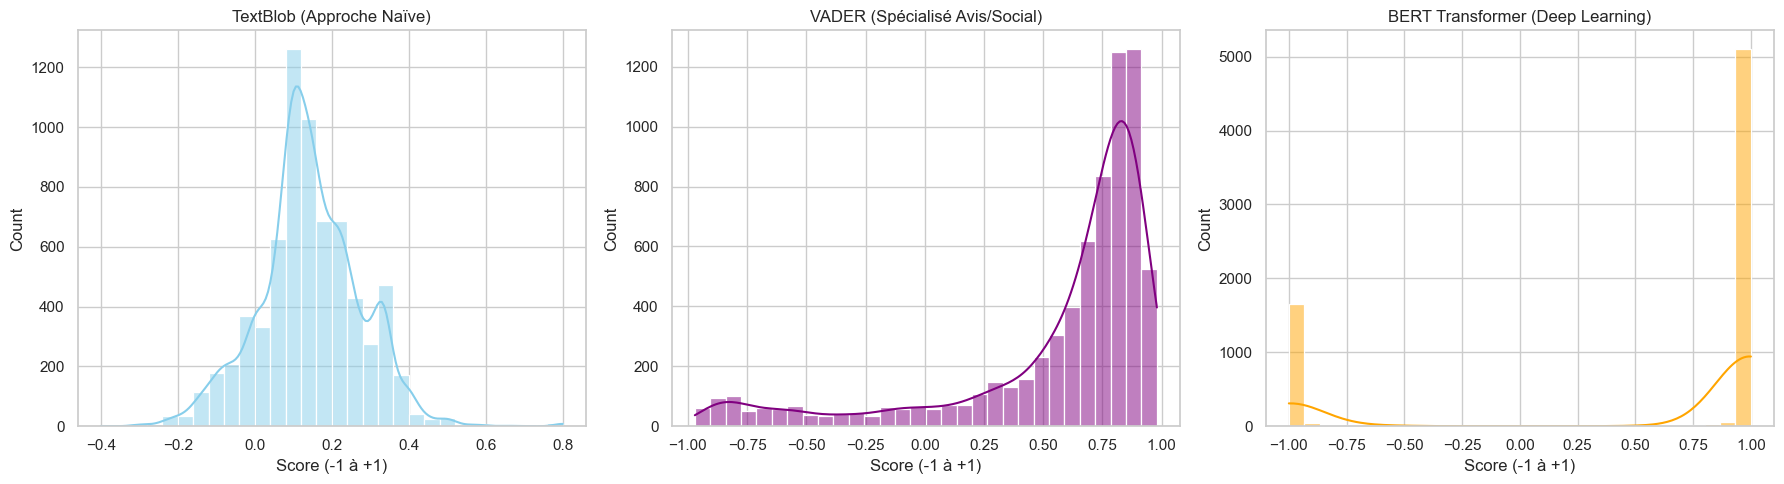

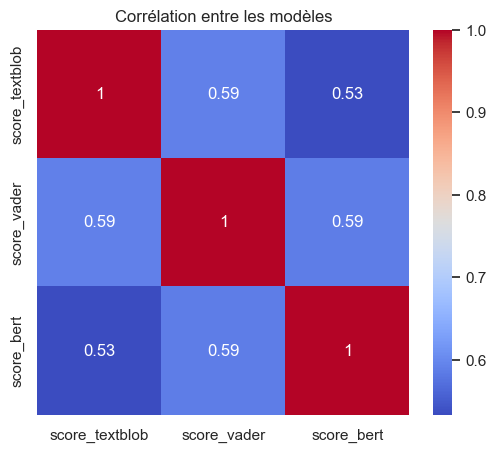

In [6]:
# 1. Initialisation des modèles
# A. VADER
analyzer_vader = SentimentIntensityAnalyzer()

# B. BERT (Hugging Face)
# On utilise un modèle "distilbert" finetuné pour le sentiment.
# 'top_k=None' permet d'avoir tous les scores
print("Chargement du modèle Deep Learning...")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Fonctions de calcul

def get_vader_score(text):
    # VADER aime le texte BRUT (avec ponctuation)
    return analyzer_vader.polarity_scores(str(text))['compound']

def get_textblob_score(text):
    # TextBlob aime le texte un peu nettoyé
    return TextBlob(str(text)).sentiment.polarity

def get_bert_score(text):
    # BERT a une limite de 512 mots, on coupe si c'est trop long
    text = str(text)[:512]
    try:
        result = sentiment_pipeline(text)[0]
        # Le modèle retourne LABEL='POSITIVE'/'NEGATIVE' et un score de confiance (0 à 1)
        # On transforme ça en score -1 à +1 pour comparer avec les autres
        score = result['score']
        label = result['label']

        if label == 'NEGATIVE':
            return -score # On inverse le score pour les négatifs
        else:
            return score
    except:
        return 0.0

# 2. Application sur le DataFrame
print("Calcul des scores en cours sur les 3 modèles...")

# On utilise tqdm pour voir la barre de progression car BERT prend du temps
tqdm.pandas()

df['score_vader'] = df['CustomerFeedback'].progress_apply(get_vader_score)
df['score_textblob'] = df['cleaned_feedback'].progress_apply(get_textblob_score)
df['score_bert'] = df['CustomerFeedback'].progress_apply(get_bert_score)

# 3. Comparaison Visuelle des 3 modèles
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['score_textblob'], bins=30, kde=True, color='skyblue')
plt.title('TextBlob (Approche Naïve)')
plt.xlabel('Score (-1 à +1)')

plt.subplot(1, 3, 2)
sns.histplot(df['score_vader'], bins=30, kde=True, color='purple')
plt.title('VADER (Spécialisé Avis/Social)')
plt.xlabel('Score (-1 à +1)')

plt.subplot(1, 3, 3)
sns.histplot(df['score_bert'], bins=30, kde=True, color='orange')
plt.title('BERT Transformer (Deep Learning)')
plt.xlabel('Score (-1 à +1)')

plt.tight_layout()
plt.show()

# Matrice de corrélation pour voir s'ils sont d'accord
plt.figure(figsize=(6, 5))
sns.heatmap(df[['score_textblob', 'score_vader', 'score_bert']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les modèles")
plt.show()

# CATEGORISATION (Approche Hybride VADER + BERT)

/var/folders/kv/0vnl_n510xscv9qm_59rfwyw0000gn/T/ipykernel_7964/2163797400.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, order=order_list, palette='RdYlGn')


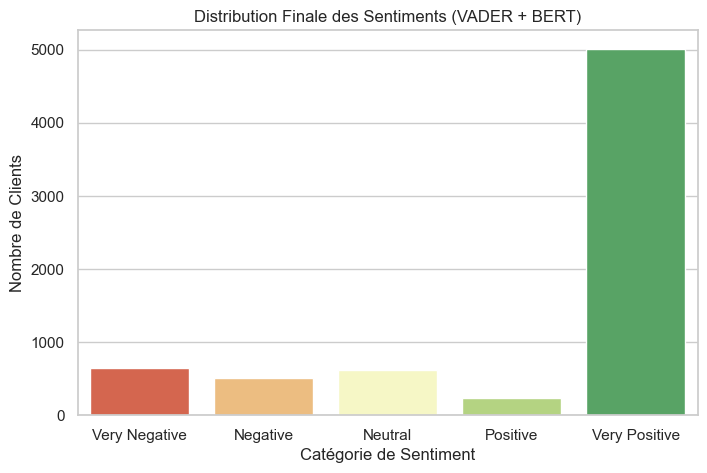

Statistiques de la méthode Hybride :
sentiment_category
Very Positive    0.713026
Very Negative    0.091581
Neutral          0.088311
Negative         0.073237
Positive         0.033845
Name: proportion, dtype: float64


In [7]:
# On crée un score moyen pondéré (On fait confiance à BERT et VADER)
# TextBlob est souvent moins bon, on l'ignore pour la finale.
df['final_sentiment_score'] = (df['score_vader'] + df['score_bert']) / 2

def categorize_sentiment_en(score):
    if score <= -0.6:
        return "Very Negative"
    elif score <= -0.2:
        return "Negative"
    elif score < 0.2:
        return "Neutral"
    elif score < 0.6:
        return "Positive"
    else:
        return "Very Positive"

# Application sur le score FINAL
df['sentiment_category'] = df['final_sentiment_score'].apply(categorize_sentiment_en)

# Visualisation
plt.figure(figsize=(8, 5))
order_list = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
sns.countplot(x='sentiment_category', data=df, order=order_list, palette='RdYlGn')
plt.title('Distribution Finale des Sentiments (VADER + BERT)')
plt.xlabel('Catégorie de Sentiment')
plt.ylabel('Nombre de Clients')
plt.show()

print("Statistiques de la méthode Hybride :")
print(df['sentiment_category'].value_counts(normalize=True))

# Export Final et Packaging

In [8]:
# 1. Sélection Stratégique des Colonnes
# On ne garde que l'essentiel pour que les fichiers soient légers et clairs.

cols_to_export = [
    # IDENTIFICATION (Pour lier avec le travail de l'équipe Tabulaire)
    'Churn',               # La cible (Indispensable pour tout le monde)

    # POUR L'EQUIPE DASHBOARD (Affichage)
    'CustomerFeedback',    # Texte Brut (Pour afficher "Ce que le client a dit")
    'sentiment_category',  # Filtres (Very Positive, Negative...) pour les KPIs

    # POUR L'EQUIPE TOPIC MODELING (Analyse)
    'cleaned_feedback',    # Texte Nettoyé (Ils n'auront pas à refaire le nettoyage)

    # POUR L'EQUIPE HYBRIDE (Machine Learning)
    'final_sentiment_score' # Score Numérique (Moyenne VADER+BERT) pour l'entraînement
]

# On ajoute customerID s'il est présent (c'est mieux pour les jointures)
if 'customerID' in df.columns:
    cols_to_export.insert(0, 'customerID')

# Création du DataFrame final
df_final = df[cols_to_export]

# 2. Sauvegarde CSV
filename = 'telco_sentiment_enriched.csv'
df_final.to_csv(filename, index=False)

# 3. Rapport de Livraison
print("="*50)
print(f"✅ FICHIER GÉNÉRÉ : {filename}")
print(f"📊 Dimensions : {df_final.shape}")
print("="*50)
print("📦 CONTENU DU PAQUET POUR LES AUTRES EQUIPES :")
print("   1. Equipe Topic Modeling : Utiliser la colonne 'cleaned_feedback'")
print("   2. Equipe Modèle Hybride : Utiliser la colonne 'final_sentiment_score'")
print("   3. Equipe Dashboard      : Utiliser 'sentiment_category' et 'CustomerFeedback' ....")
print("="*50)

✅ FICHIER GÉNÉRÉ : telco_sentiment_enriched.csv
📊 Dimensions : (7032, 6)
📦 CONTENU DU PAQUET POUR LES AUTRES EQUIPES :
   1. Equipe Topic Modeling : Utiliser la colonne 'cleaned_feedback'
   2. Equipe Modèle Hybride : Utiliser la colonne 'final_sentiment_score'
   3. Equipe Dashboard      : Utiliser 'sentiment_category' et 'CustomerFeedback' ....
